In [1]:
from datascience import Table
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import copy
import mpl_scatter_density
import numpy as np
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import seaborn as sns; sns.set()
import geohash as gh
%matplotlib inline

**1. Read Dataset**

**Train Set**

In [2]:
data = pd.read_csv('train.csv')
data.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


Number of columnns & Number of Observations

In [3]:
# number of columns
data.shape[1]

11

In [4]:
# number of rows
data.shape[0]

1458644

Training Date : [1,458,644 observations,11 features ]

**Test Set**

In [5]:
test = pd.read_csv('test.csv')
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


In [6]:
# number of columns
test.shape[1]

9

In [7]:
# number of rows
test.shape[0]

625134

In [8]:
# find the columns that are in the training data and not in the test set.
data.columns.difference(test.columns)

Index(['dropoff_datetime', 'trip_duration'], dtype='object')

The test set doesn't contain all the features in the training data. It is missing the following columns: 
- Dropff datetime
- Trip duration

**2. Data Cleaning & Missing Values**

In [9]:
# Check if there is any NAN values in the train data
data.isnull().any().any()

False

In [10]:
# Check if there is any NAN values in the test data
test.isnull().any().any()

False

There is no missing values in the dataset

**Validate Consistency of the Data**

In this part the following conditions are checked for to ensure the consistenecy of the dataset: 
    - Dropoff time > pickup time
    - longitude is in the range [-180,180]
    - latitude is in the range [-90,90]
    - pickup & dropoff coordinates are within the coordinates of NYC
    - Passanger count < max capacity of yellow cabs in NYC
    - Passenger count is greater than zero

1. Check that dropoff time is greater than the pickup time.

In [11]:
# pickup time < dropoff time
(data['pickup_datetime'] < data['dropoff_datetime']).any()

True

2. Check that the longitude values are within range [0, 90] & latitude values are within the range [-180, 180].

In [12]:
# dropoff longitude values [-180, 180]
(data['dropoff_longitude'].between(-180,180, inclusive=True)).any()

True

In [13]:
# pickup longitude values [-180, 180]
(data['pickup_longitude'].between(-180,180, inclusive=True)).any()

True

In [14]:
# dropoff latitude values [-90, 90]
(data['dropoff_latitude'].between(-90,90, inclusive=True)).any()

True

In [15]:
# dropoff latitude values [-90, 90]
(data['pickup_latitude'].between(-90,90, inclusive=True)).any()

True

4. Check that the passenger count doesn't exceed the maximum capacity of NYC yellow cab.

In [16]:
# yellow cab passenger max capacity : src: https://www.tripsavvy.com/new-york-city-taxis-4026457
max_capacity = 9
(data['passenger_count'] <= max_capacity).any()

True

3. Check that the longitude & latitude values are withing the coordinates of NYC.
we got the bounding box of NYC using this site:https://gist.github.com/mishari/5ecfccd219925c04ac32

In [17]:
# bounding box of NYC
# bbox = min latitude , max Latitude , min Longitude , max longitude 
bbox = [40.4773979187012,45.0158615112305,-79.7625122070312,-71.8527069091797]

In [18]:
data['pickup_latitude'].between(bbox[0], bbox[1], inclusive=True).any()

True

In [19]:
data['dropoff_latitude'].between(bbox[0], bbox[1], inclusive=True).any()

True

In [20]:
data['pickup_longitude'].between(bbox[2], bbox[3], inclusive=True).any()

True

In [21]:
data['dropoff_longitude'].between(bbox[2], bbox[3], inclusive=True).any()

True

**Data Visualization**

- **Vendors & Number of rides**

In [22]:
vendors = pd.DataFrame({'count':data[['vendor_id']].groupby('vendor_id').size()}).reset_index()

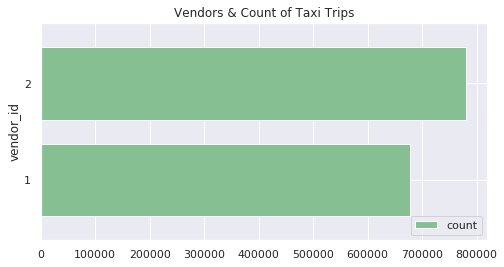

In [23]:
vendors.plot(x='vendor_id', y='count', kind='barh' ,figsize=(8, 4), color='#86bf91', zorder=2, width=0.75, title="Vendors & Count of Taxi Trips")

- **Passanger Count**

In [24]:
passenger = pd.DataFrame({'count':data[['passenger_count']].groupby('passenger_count').size()}).reset_index()
passenger

,passenger_count,count
0,0,60
1,1,1033540
2,2,210318
3,3,59896
4,4,28404
5,5,78088
6,6,48333
7,7,3
8,8,1
9,9,1


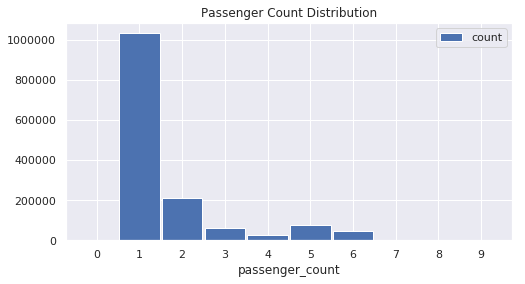

In [25]:
passenger.plot.bar(x='passenger_count', y='count', rot=0, figsize=(8, 4), color='b', zorder=2, width=0.95, title="Passenger Count Distribution")

**Observations**

- There are trips with passenger count = 0. This indicates that the trip was made as to deliver something.
- passenger count greater than 6 is extremely rare to happen

- **Pickup Date & time**

- Day Hour

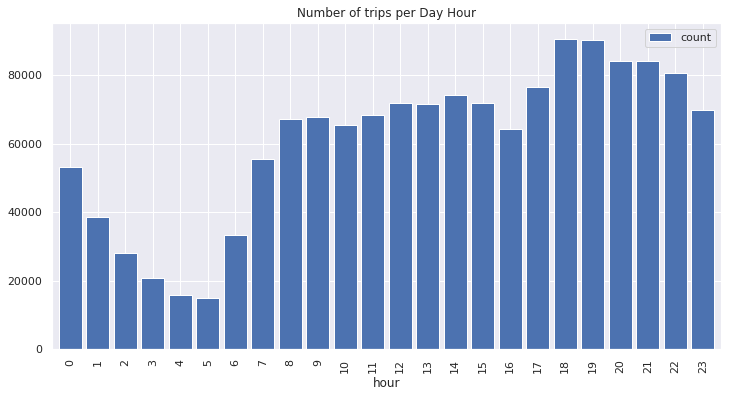

In [26]:
# convert pickup to datetime object
dayhour = pd.DataFrame({'hour': pd.to_datetime(data['pickup_datetime']).dt.hour}).groupby('hour').size()
dayhour = pd.DataFrame({'count': dayhour}).reset_index()
dayhour.plot.bar(x='hour', y='count', figsize=(12, 6), color='b', zorder=2, width=0.85, title="Number of trips per Day Hour")

- Weekdays

In [27]:
# convert pickup to datetime object
weekdays = pd.DataFrame({'day': pd.to_datetime(data['pickup_datetime']).dt.day_name()}).groupby('day').size()
weekdays = pd.DataFrame({'count': weekdays}).reset_index()
weekdays

,day,count
0,Friday,223533
1,Monday,187418
2,Saturday,220868
3,Sunday,195366
4,Thursday,218574
5,Tuesday,202749
6,Wednesday,210136


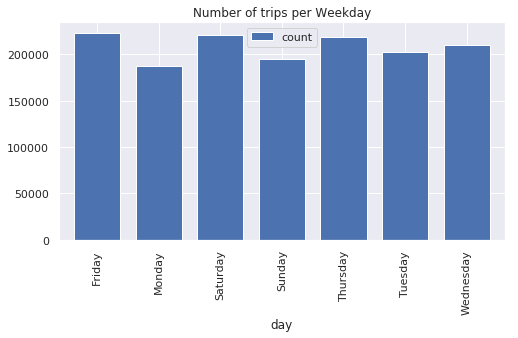

In [28]:
weekdays.plot.bar(x='day', y='count', figsize=(8, 4), color='b', zorder=2, width=0.75, title="Number of trips per Weekday")

**Observations**

- Friday has the highest number of trips
- Monday has the lowest number of trips

- Months

In [29]:
# convert pickup to datetime object
months = pd.DataFrame({'month': pd.to_datetime(data['pickup_datetime']).dt.month_name()}).groupby('month').size()
months = pd.DataFrame({'count': months}).reset_index()
months

,month,count
0,April,251645
1,February,238300
2,January,229707
3,June,234316
4,March,256189
5,May,248487


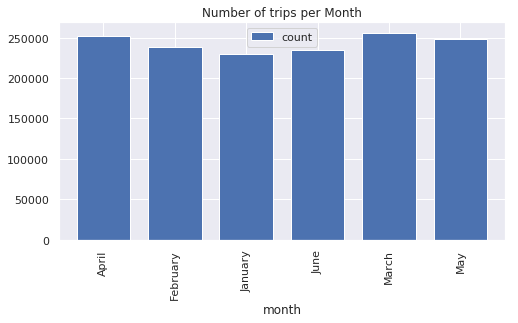

In [30]:
months.plot.bar(x='month', y='count', figsize=(8, 4), color='b', zorder=2, width=0.75, title="Number of trips per Month")

**Heatmaps**

**1. Month-Hour & Number of Pickups**

In [33]:
month_hour = pd.DataFrame({'month': pd.to_datetime(data['pickup_datetime']).dt.month_name(),
                           'hour' : pd.to_datetime(data['pickup_datetime']).dt.hour}).groupby(['month', 'hour']).size()
month_hour = pd.DataFrame({'count': month_hour}).reset_index()

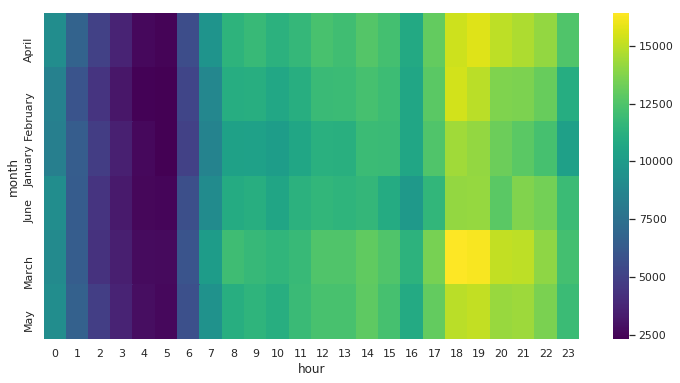

In [34]:
result = month_hour.pivot(index='month', columns='hour', values='count')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

**2. Month-Day & Number of Pickups**

In [36]:
month_day = pd.DataFrame({'month': pd.to_datetime(data['pickup_datetime']).dt.month_name(),
                           'day' : pd.to_datetime(data['pickup_datetime']).dt.day_name()}).groupby(['month', 'day']).size()
month_day = pd.DataFrame({'count': month_day}).reset_index()

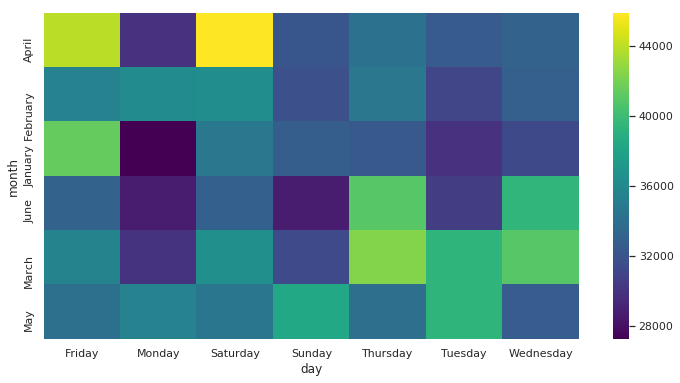

In [38]:
result = month_day.pivot(index='month', columns='day', values='count')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

**1. Day-Hour & Number of Pickups**

In [42]:
day_hour = pd.DataFrame({'day': pd.to_datetime(data['pickup_datetime']).dt.day_name(),
                           'hour' : pd.to_datetime(data['pickup_datetime']).dt.hour}).groupby(['day', 'hour']).size()
day_hour = pd.DataFrame({'count': day_hour}).reset_index()

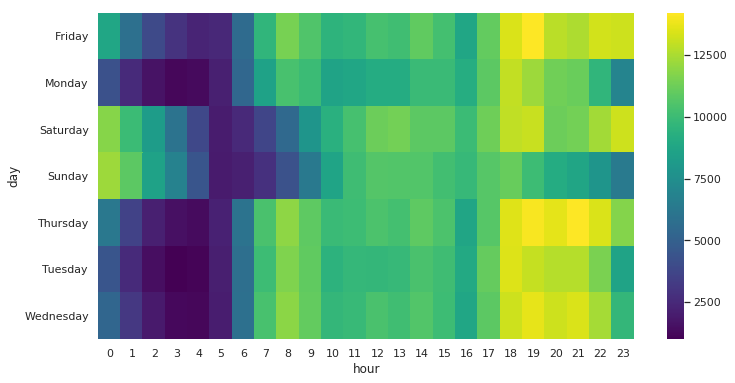

In [43]:
result = day_hour.pivot(index='day', columns='hour', values='count')
fig, ax = plt.subplots(figsize=(12,6))         # Sample figsize in inches
sns.heatmap(result, annot=False, fmt="g", cmap='viridis', ax=ax)
plt.show()

**Pickup Longitude & Pickup Latitude**

In [80]:
# list of longitudes & latitudes and the bounding box of new york
def density_map(latitudes, longitudes , bbox):  
    norm = ImageNormalize(vmin=0., vmax=1000, stretch=LogStretch())
    plt.figure(figsize=(15,15))
    ax = plt.subplot(1, 1, 1, projection='scatter_density')

    xmin = bbox[0]
    xmax = bbox[1]
    ymin = bbox[2]
    ymax = bbox[3]
    
    xmin = -74.15
    xmax = -73.75
    ymin = 40.62
    ymax = 40.85
    
    aspect = 1 / np.cos(np.radians(0.5 * (ymin + ymax)))

    ax.scatter_density(longitudes, latitudes, cmap='plasma', norm=norm)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel
    ax.set_aspect(aspect)

In [81]:
# Coordinates of new york's city center
nyc = [74.0060, 40.7128]  

**Pickup Locations**

In [82]:
# Separate the latitude and longitude values from our list of coordinates
pickup_lat = np.array(data['pickup_latitude'])
pickup_long = np.array(data['pickup_longitude'])

In [ ]:
# bounding box of the pickup locations
# bbox = min Longitude , max longitude , min latitude , max Latitude , 
bbox = []
bbox.append(np.min(pickup_long))
bbox.append(np.max(pickup_long))
bbox.append(np.min(pickup_lat))
bbox.append(np.max(pickup_lat))

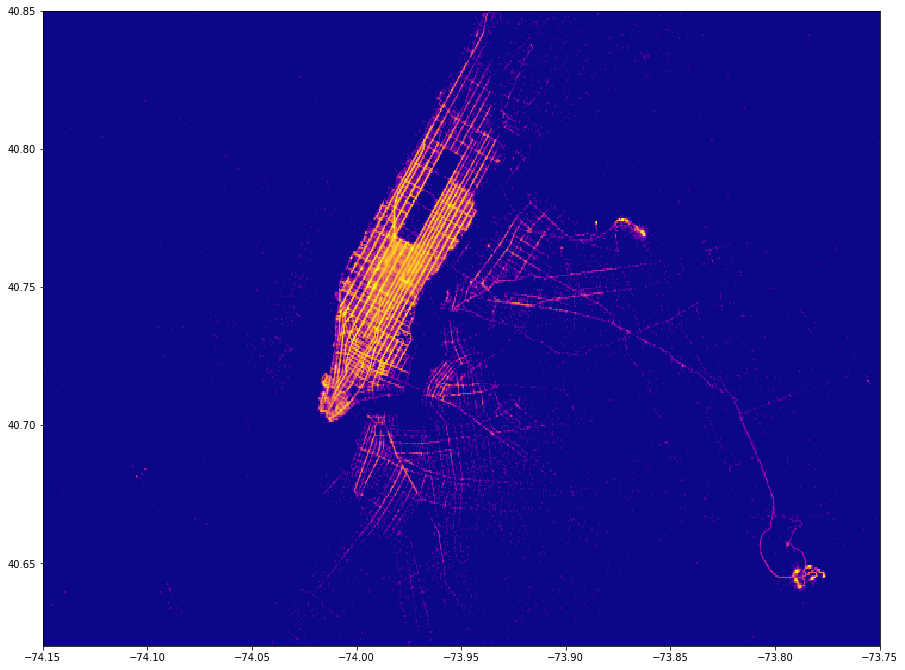

In [83]:
# Render the map
density_map(pickup_lat, pickup_long, bbox)

**Observations**

- What are the busiest routes ?

**Dropoff Locations**

In [78]:
# Separate the latitude and longitude values from our list of coordinates
dropoff_lat = np.array(data['dropoff_latitude'])
dropoff_long = np.array(data['dropoff_longitude'])

In [ ]:
# bounding box of the pickup locations
# bbox = min Longitude , max longitude , min latitude , max Latitude , 
bbox = []
bbox.append(np.min(dropoff_long))
bbox.append(np.max(dropoff_long))
bbox.append(np.min(dropoff_lat))
bbox.append(np.max(dropoff_lat))

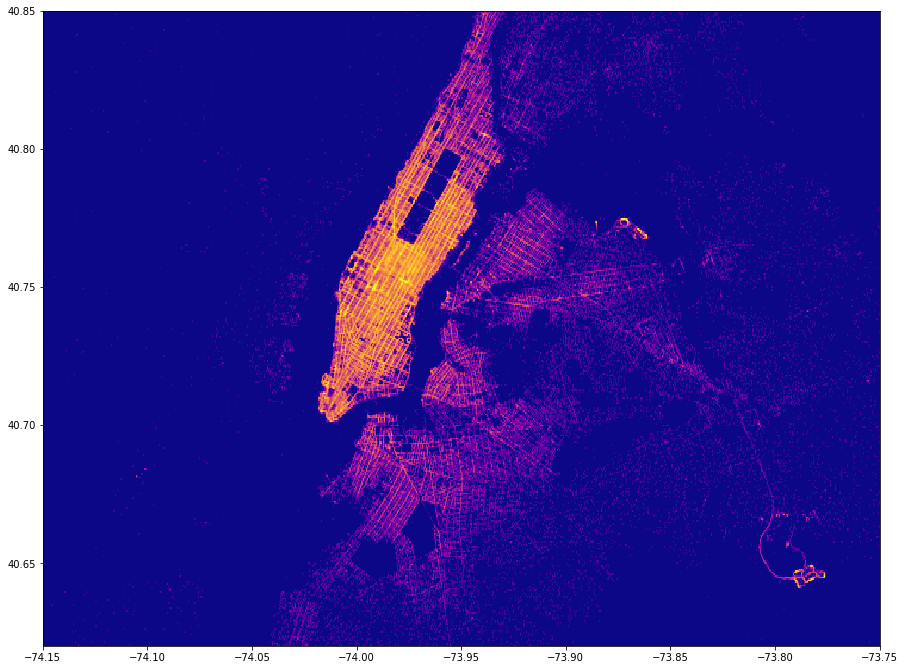

In [84]:
# Render the map
density_map(dropoff_lat, dropoff_long, bbox)

**Trip Duration**

In [113]:
max_dur = np.max(data['trip_duration'])

In [114]:
min_dur = np.min(data['trip_duration'])

**Outliers Anaylysis**

- Outliers in the passenger count: 
    - Why are there trips with passenger count = 0 ? 
    - Trips with passanger count = 9 & 8 & 7 are extremely rare. Who took those rides and from which pickup location and to which dropoff location ? 

**Dataset Descriptive Statistics**

- Estimate mean & median of passenger count
- Estimate mean & median of trip duration

**Feature Engineering**

1. Discrete Time 
2. Discrete Location 

In this part, we convert pair values of longitude and latitude to a discrete value using the geohash python library. 

In [147]:
data['pickup_geohash'] = data.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1)

In [149]:
data['dropoff_geohash'] = data.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1)

**Pickup & Dropoff locations Distribution**

**Merge With the Weather Data**

**Feature Relations**